# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

import torch
import torchvision
import torchvision.transforms as transforms

다음은 dataset을 준비합니다. 손글씨 dataset은 MNIST라는 유명한 dataset이 있습니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

In [2]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=False,
    transform=transform
)

MNIST는 손글씨 사진과 어떤 숫자를 의미하는지에 대한 label의 pair들로 구성되어있습니다.
이 때, 우리는 PyTorch model을 사용할 것이기 때문에 손글씨 사진들을 모두 tensor로 변환해야합니다.
이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며, `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.
우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.

다음은 전체 data의 개수와 첫 번째 data를 출력한 결과입니다.

60000
torch.Size([1, 28, 28]) 5


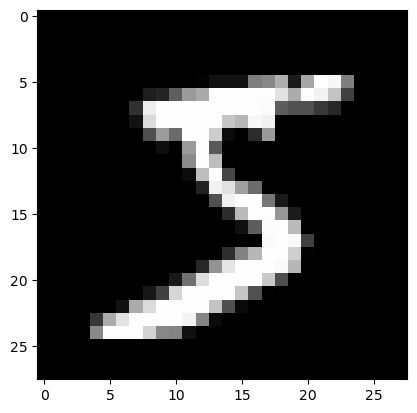

In [3]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')


# NOTE

데이터 셋 구성

trainset[테스트 데이터 갯수][데이터와 정답, 튜플]
0 : 데이터 텐서
1 : 정답 값

shape 는 텐서에서만 쓸 수 있는 메서드라 길이 파악을 다르게 해야 함

In [17]:

print( type(trainset))
print( type(trainset[0]))
print(len(trainset[0]))
print( type(trainset[0][0]))
print( type(trainset[0][1]))


<class 'torchvision.datasets.mnist.MNIST'>
<class 'tuple'>
2
<class 'torch.Tensor'>
<class 'int'>


첫 번째 출력결과를 통해 우리는 6만장의 손글씨 data가 있는 것을 알 수 있습니다.
그리고 두 번째 출력결과를 통해 첫 번째 data의 shape은 (1, 28, 28)이고 5라는 숫자를 쓴 사진이라는 것을 알 수 있습니다.
마지막으로 `plt.imshow`를 통해 visualize 했을 때 5라는 숫자가 나오는 것을 알 수 있습니다.

다음은 SGD를 위해 dataset을 여러 개의 batch로 나누는 과정을 PyTorch로 구현한 모습입니다.

# NOTE

batch_size 를 통해 데이터를 로드하는 이유는 GPU 에 데이터를 한번에 넣기 위함임
이는 x.T를 하던 것과 맥락이 같음

In [4]:
batch_size = 64

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

PyTorch에서는 `DataLoader`가 dataset을 인자로 받아 batch로 나눠줍니다.
부가적으로 `batch_size`라는 인자를 통해 batch size를 받고 있으며, `shuffle`이라는 인자를 통해 data들을 섞을지 결정해줍니다.
우리는 SGD가 완전 랜덤으로 batch를 구성해야 잘 동작하는 것을 알고 있기 때문에 `shuffle`에 `True`를 넘겨주고 있습니다.

다음은 첫 번째 batch를 출력한 모습입니다.

# NOTE
iter 는 이터러블 데이터에 접근하는 이터레이터를 만드는 것
next는 이터러블 데이터에 순차적으로 접근하는 것

# 파이썬 프로그래밍 기본 용어 설명

## iter
```python
dataiter = iter(trainloader)
```
**설명**: `iter()` 함수는 반복 가능한(iterable) 객체로부터 이터레이터(iterator)를 생성합니다. 이터레이터는 데이터 컬렉션의 요소들을 하나씩 접근할 수 있게 해주는 객체입니다. 위 코드에서는 `trainloader`라는 데이터 로더에서 이터레이터를 생성하여 `dataiter` 변수에 저장하고 있습니다.

## next
```python
images, labels = next(dataiter)
```
**설명**: `next()` 함수는 이터레이터에서 다음 요소를 가져옵니다. 이터레이터가 가리키는 현재 요소를 반환하고, 이터레이터의 포인터를 다음 요소로 이동시킵니다. 위 코드에서는 `dataiter`에서 다음 배치의 데이터를 가져와 `images`와 `labels` 변수에 각각 할당하고 있습니다. 이 경우 `images`에는 이미지 데이터가, `labels`에는 해당 이미지들의 레이블(정답) 데이터가 저장됩니다.

귀하의 정의는 정확합니다. `iter`는 이터러블 데이터에 접근하는 이터레이터를 만드는 것이고, `next`는 이터레이터를 통해 이터러블 데이터에 순차적으로 접근하는 기능을 합니다.

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


`images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.
위에서 batch size를 64로 설정했기 때문에 총 64개의 image와 label들이 있어야 합니다.
실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

다음은 (n, 1, 28, 28) shape의 image를 입력받아 0~9 사이의 정수 하나를 출력하는 3-layer MLP를 구현합니다.

# NOTE

모델 정의는 모델 초기 설정을 구성하는 것이라 보는게 좋다
이러한 설정을 한다~~ 의 개념

In [6]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 1)

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x


model = Model(28 * 28 * 1, 1024)

이전의 2-layer MLP와 유사한 형태임을 알 수 있습니다.
여기서 특이사항은 `forward`의 첫 번째 줄에 `torch.flatten`을 사용한다는 것입니다.
`Linear`는 이전에도 봤다시피 (n, d) 형태의 shape을 입력받습니다.
이미지는 (n, 1, 28, 28)이기 때문에 (n, 1 * 28 * 28)로 shape을 변환해야 선형 함수에 입력으로 주어줄 수 있게 됩니다.
이 역할을 수행하는 것이 바로 `torch.flatten`입니다.
우리는 첫 번째 shape인 n을 보존할 것이기 때문에 flatten할 차원은 `start_dim=1`로 넘겨주게 됩니다.

다음은 gradient descent를 수행해줄 optimizer를 구현하는 모습입니다.

x 의 값의 flatten 는 

In [7]:
from torch.optim import SGD

lr = 0.001
model = model.to('cuda')

optimizer = SGD(model.parameters(), lr=lr)

이전 코드와 거의 똑같습니다. 다른 점은 `model.to('cuda')` 코드를 통해 우리가 구현한 model을 GPU로 옮긴 것입니다.
MNIST 부터는 모델과 data가 커지면서 훨씬 많은 행렬 연산이 이루어지기 때문에 GPU를 활용하는 것이 빠릅니다.

다음은 model을 MNIST에 학습하는 코드입니다.

In [8]:
from tqdm import tqdm

n_epochs = 100

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = (preds[:, 0] - labels).pow(2).mean()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(  f"Epoch {epoch:3d} | Loss: {total_loss} ")

Epoch   0 | Loss: 4698.828727006912
Epoch   1 | Loss: 2535.568864107132
Epoch   2 | Loss: 1832.3663831949234
Epoch   3 | Loss: 1444.4931572675705
Epoch   4 | Loss: 1214.5515488386154
Epoch   5 | Loss: 1068.825223237276
Epoch   6 | Loss: 968.6588402986526
Epoch   7 | Loss: 893.0991212129593
Epoch   8 | Loss: 834.623433470726
Epoch   9 | Loss: 783.4425313770771
Epoch  10 | Loss: 740.6098617017269
Epoch  11 | Loss: 703.3354276269674
Epoch  12 | Loss: 672.0533530414104
Epoch  13 | Loss: 644.4559734761715
Epoch  14 | Loss: 616.0347243696451
Epoch  15 | Loss: 591.9961325526237
Epoch  16 | Loss: 570.0822671204805
Epoch  17 | Loss: 551.4800537675619
Epoch  18 | Loss: 532.8771891444921
Epoch  19 | Loss: 514.1789037287235
Epoch  20 | Loss: 494.345527485013
Epoch  21 | Loss: 482.62303283810616
Epoch  22 | Loss: 470.8248125463724


KeyboardInterrupt: 

출력 결과를 보면 잘 수렴하는 것을 볼 수 있습니다.
이전 구현과 다른 점은 다음 두 가지입니다.
- `for data in trainloader`를 통해 batch들을 iterate하면서 model을 학습합니다.
- `inputs, labels = inputs.to('cuda'), labels.to('cuda')`를 통해 model의 입력으로 들어가는 tensor들을 GPU로 보냅니다.

마지막으로 첫 번째 data에 대한 예측 결과를 살펴봅시다.

In [9]:
idx = 0

x = trainset[idx][0][None]  # (1, 1, 28, 28)
x = x.to('cuda')

print(model(x))
print(trainset[idx][1])

tensor([[3.8280]], device='cuda:0', grad_fn=<ReluBackward0>)
5


여기서 idx를 조정하여 다른 data에 대한 출력 결과도 볼 수 있습니다.
예측 결과를 보시면 아직 성능이 그렇게 좋지 않은 것을 알 수 있습니다.